In [3]:
import torch
import time
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_acc
from snn_delays.utils.visualization_utils import plot_distributions, plot_param
device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
          
num_epochs = 50

lr = 5e-4
# SNN CON DELAYS
taimu1 = time.time()

#tau_m = 'normal'
tau_m = 20.0
delay = (48,16)
#delay = None
#delay = (3, 1)
ckpt_dir = 'exp3_shd50'

snn = SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='f',
    delay=delay, delay_type='h', tau_m = tau_m,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=False)

snn.input2spike_th = None

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]

[INFO] Delays: tensor([ 0, 16, 32])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0, 16, 32])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.0 ms


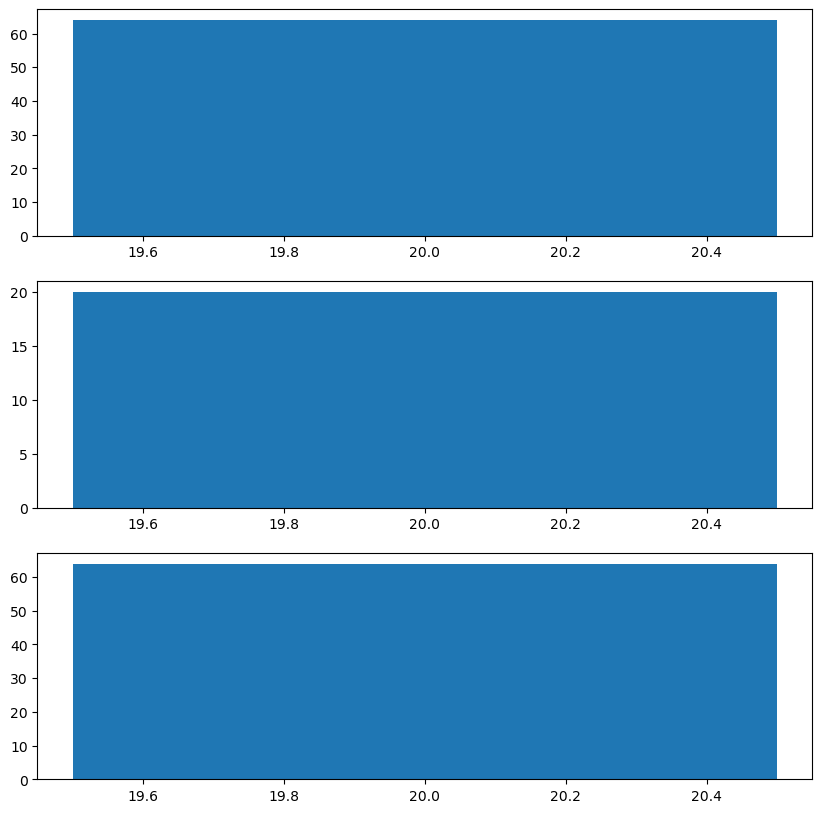

In [4]:
import numpy as np
import matplotlib.pyplot as plt
delta_t = (1e3/total_time) # in miliseconds

def sigmoid(x):
  return 1 / (1 + np.exp(-x))
transform = lambda x: -delta_t/np.log(sigmoid(x))
plt.figure(figsize=(10,10))
for i in range(3):
  plt.subplot(3, 1, i+1)
  plot_param(snn.tau_params[i], transform=transform)
plt.show()

After Training

In [3]:
snn.to(device)
train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, lr_scale_tau=20.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

training shd50_SNN_l2_48d16.t7 for 50 epochs...
Epoch [1/50], learning_rates 0.000500, 0.010000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to re

Step [2/7], Loss: 3.32567
l1_score: 0
Step [4/7], Loss: 3.09674
l1_score: 0
Step [6/7], Loss: 3.14490
l1_score: 0
Step [8/7], Loss: 3.13538
l1_score: 0
Time elasped: 46.39951014518738
Test Loss: 4.622810244560242
Avg spk_count per neuron for all 50 time-steps 3.058150291442871
Avg spk per neuron per layer [7.424366442137809, 4.808234871908128]
Test Accuracy of the model on the test samples: 5.565

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp3_shd50
Gradient norm for 'tau_m_1': 0.0001
Gradient norm for 'tau_m_2': 0.0016
Gradient norm for 'tau_m_o': 0.0249
Gradient norm for 'f0_f1.weight': 0.0779
Gradient norm for 'f1_f2.weight': 0.2749
Gradient norm for 'f2_o.weight': 1.1561
saving max acc: 5.565371024734982
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp3_shd50
Epoch [2/50], learning_rates 0.000500, 0.010000
Step [2/7], Loss: 3.04143
l1_score: 0
Step [4/7], Loss: 3.04005
l1_score: 0
Step [6/7

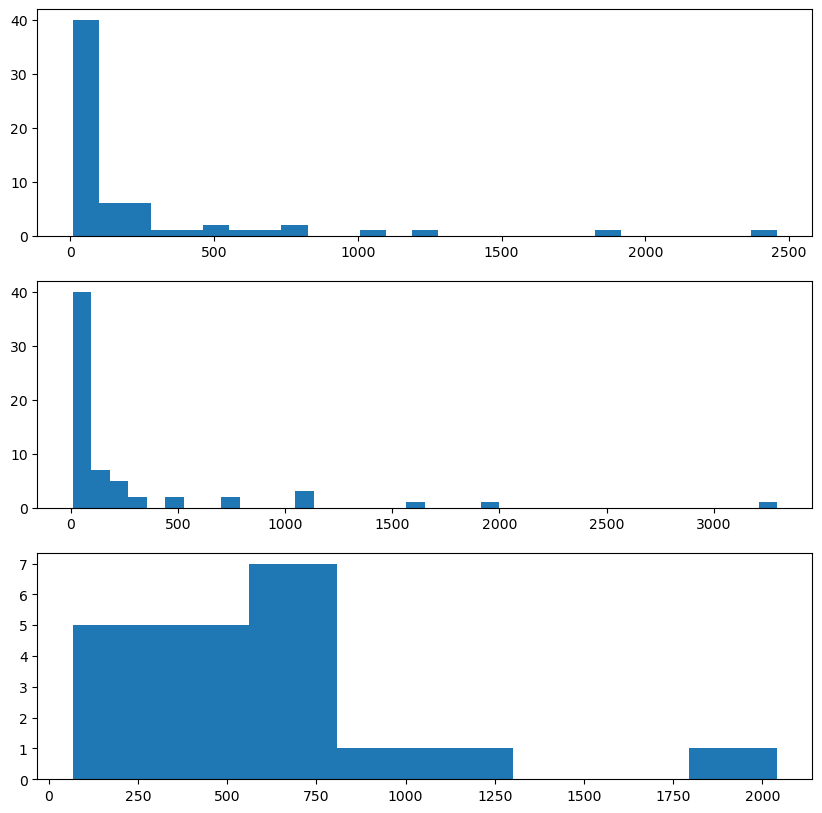

In [29]:
plt.figure(figsize=(10,10))
for i in range(3):
  plt.subplot(3, 1, i+1)
  plot_param(snn.tau_params[i], transform=transform)
plt.show()

In [8]:
from snn_delays.utils.hw_aware_utils import scale_weights
from snn_delays.utils.train_utils import copy_snn

snn = SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='f',
    delay=delay, delay_type='h', tau_m = tau_m,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=False)

snn.input2spike_th = None

snn2 = copy_snn(snn)

scaling_factor = 0.1

snn2.f0_f1.weight.data = scaling_factor*snn2.f0_f1.weight.data
snn2.f1_f2.weight.data = scaling_factor*snn2.f1_f2.weight.data
snn2.f2_o.weight.data = scaling_factor*snn2.f2_o.weight.data

snn2.input2spike_th = None

# print('AFTER WEIGHT SCALING')
# scale_weights(snn2.f0_f1, scaling_factor)
# scale_weights(snn2.f1_f2, scaling_factor)
# scale_weights(snn2.f2_o, scaling_factor)

snn2.to(device)
train(snn2, train_loader, test_loader, lr, num_epochs, dropout=0.0, lr_scale_tau=20.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)


[INFO] Delays: tensor([ 0, 16, 32])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0, 16, 32])

[INFO] Delays o: tensor([0])
Delta t: 20.0 ms
mean of normal: -0.541324854612918

[INFO] Delays: tensor([ 0, 16, 32])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0, 16, 32])

[INFO] Delays o: tensor([0])
Delta t: 20.0 ms
mean of normal: -0.541324854612918
training shd50_SNN_l2_48d16.t7 for 50 epochs...
Epoch [1/50], learning_rates 0.000500, 0.010000
Step [2/7], Loss: 2.99573
l1_score: 0
Step [4/7], Loss: 2.99573
l1_score: 0
Step [6/7], Loss: 2.99573
l1_score: 0
Step [8/7], Loss: 2.99573
l1_score: 0
Time elasped: 3.2934675216674805
Test Loss: 4.493598818778992
Avg spk_count per neuron for all 50 time-steps 0.46482130885124207
Avg spk per neuron per layer [1.859285280477032, 0.0]
Test Accuracy of the model on the test samples: 4.549

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp3_shd50
Gradient norm for 'tau_m_1': 0.0000
G